In [1]:
import gc
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit, fit_model_cv, plotCoefficients
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [2]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [3]:
tr_val = setindexdatetime(pd.read_csv('valids/tr_val/tr_val.csv'),'Timestamp')
tr_tr = setindexdatetime(pd.read_csv('valids/tr_val/tr_train.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')
tr_tr.index.freq = '15T'
tr_val.index.freq = '15T'
ts = resample(ts)

/home/berkkarahan/Desktop/tupras/helpers/funcs.py:38: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras/helpers/funcs.py:72: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras/helpers/funcs.py:75: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [4]:
targ = tr_tr.Target.copy().values.reshape(-1,1)
exog = tr_tr.drop('Target',1).values

In [5]:
targ.shape

(34272, 1)

In [6]:
import copy
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [9]:
c_list=[]
for i, tpl in enumerate(tscv.split(tr_tr)):
    print(str(i) + "-th iteration started...")
    tr_i = tpl[0]
    y_ = targ[tr_i,:]
    exog_ = exog[tr_i,:]
    rf = auto_arima(y_,
                exogenous = exog_,
                start_p=1,
                start_q=1,
                max_p=3,
                max_q=3,
                seasonal=True,
                max_P=3,
                max_Q=3,
                D = 4,
                max_D = 4,
                m = 4,
                trace=True,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=False,
                random=True,
                n_jobs=-1,
                random_state=NB_SEED)
    c_list.append(rf)
    
    

0-th iteration started...
Fit ARIMA: order=(1, 0, 3) seasonal_order=(2, 4, 3, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(2, 4, 3, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 4, 1, 4); AIC=-13290.579, BIC=-13124.391, Fit time=195.175 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(2, 4, 1, 4); AIC=-12228.616, BIC=-12062.428, Fit time=255.729 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(3, 4, 1, 4); AIC=-11404.187, BIC=-11231.352, Fit time=294.080 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(3, 4, 1, 4); AIC=-1199

MaybeEncodingError: Error sending result: '[ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(3, 4, 1, 4), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')]'. Reason: 'error("'i' format requires -2147483648 <= number <= 2147483647",)'

In [10]:
from sklearn.externals import joblib
import pickle
for i, mdl in enumerate(c_list):
    joblib.dump(mdl,'arimaseries/arima_exog_'+str(i)+'_.pkl')

In [12]:
cvpreds_tr = np.empty(shape=(tr_tr.shape[0],len(c_list)))
cvpreds_val = np.empty(shape=(tr_val.shape[0],len(c_list)))
for i, amdl in enumerate(c_list):
    y_train = amdl.predict(n_periods=tr_tr.shape[0], exogenous=tr_tr.drop('Target',1).values)
    y_pred = amdl.predict(n_periods=tr_val.shape[0], exogenous=tr_val.drop('Target',1).values)
    cvpreds_tr[:,i] = y_train
    cvpreds_val[:,i] = y_pred
    


In [13]:
cvpreds_tr = np.mean(cvpreds_tr, axis=1)
cvpreds_val = np.mean(cvpreds_val, axis=1)

In [14]:
cvpreds_tr = pd.Series(data=cvpreds_tr, index=tr_tr.index)
cvpreds_val = pd.Series(data=cvpreds_val, index=tr_val.index)

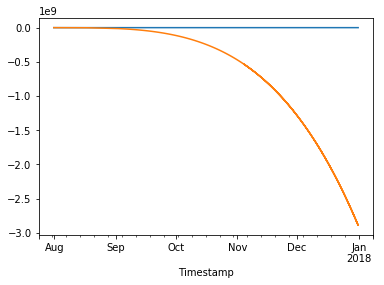

In [16]:
tr_val.Target.plot()
cvpreds_val.plot()

In [20]:
cvpreds_tr

Timestamp
2016-08-08 16:00:00    4.260426e+02
2016-08-08 16:15:00    4.263298e+02
2016-08-08 16:30:00    4.266338e+02
2016-08-08 16:45:00    4.269352e+02
2016-08-08 17:00:00    4.273753e+02
2016-08-08 17:15:00    4.277279e+02
2016-08-08 17:30:00    4.281090e+02
2016-08-08 17:45:00    4.284819e+02
2016-08-08 18:00:00    4.289068e+02
2016-08-08 18:15:00    4.291758e+02
2016-08-08 18:30:00    4.294875e+02
2016-08-08 18:45:00    4.297829e+02
2016-08-08 19:00:00    4.301553e+02
2016-08-08 19:15:00    4.302966e+02
2016-08-08 19:30:00    4.305026e+02
2016-08-08 19:45:00    4.306843e+02
2016-08-08 20:00:00    4.309752e+02
2016-08-08 20:15:00    4.309488e+02
2016-08-08 20:30:00    4.310156e+02
2016-08-08 20:45:00    4.310479e+02
2016-08-08 21:00:00    4.312292e+02
2016-08-08 21:15:00    4.309953e+02
2016-08-08 21:30:00    4.308900e+02
2016-08-08 21:45:00    4.307379e+02
2016-08-08 22:00:00    4.307826e+02
2016-08-08 22:15:00    4.303016e+02
2016-08-08 22:30:00    4.299922e+02
2016-08-08 22:45:0

In [17]:
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [22]:
#metrics train
mse_tr = mean_squared_error(tr_tr.Target,cvpreds_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(tr_tr.Target,cvpreds_tr)
r2_tr = r2_score(tr_tr.Target,cvpreds_tr)
#metrics test
mse_ts = mean_squared_error(tr_val.Target,cvpreds_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(tr_val.Target,cvpreds_val)
r2_ts = r2_score(tr_val.Target,cvpreds_val)

In [23]:
#mse
print_metric(mse_tr,mse_ts,'MSE')

MSE train: 5.431299838232005e+20 test: 1.0158044356890136e+18


In [24]:
#rmse
print_metric(rmse_tr,rmse_ts,'RMSE')

RMSE train: 23305149298.453346 test: 1007871239.637789


In [25]:
#mae
print(mae_tr,mae_ts,'MAE')

14304922457.288055 629770337.5864949 MAE


In [26]:
#r2
print(r2_tr,r2_ts,'R2')

-2.0096271949470147e+19 -2.847364700112643e+16 R2
